### Import Dependencies and Data

In [5]:
import pandas as pd
import scipy as sp  #scientific computer package
import numpy as np   #math and array package
from numpy import exp, sqrt, pi, log, array   #math functions
import matplotlib.pyplot as plt  #plotting package
from matplotlib.pyplot import xlabel, ylabel
import seaborn as sns   #plotting style package
from scipy import optimize

from openpyxl import load_workbook  #excel interface package


import time

import Sorption_Reference
import Full_Thermo
import Simple_Thermo
from Simple_Thermo import *
from Sorption_Reference import * # maybe change "all" to the only methods used: lam_solver(), Tempset(), anything else? Anyway, import all for now
from Full_Thermo import *

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)  # suppress log and sqrt warnings from Sorption_Reference.py
pd.options.mode.chained_assignment = None 

# TRI data - upload
dvs_data = pd.read_excel('./ChemRev_Hydration_Data.xlsx', sheet_name='HydrationData',
                        usecols = 'A:R')   #importing experimental data
#cols.remove('notes')
dvs_data.shape

c:\Users\andyt\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\andyt\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


(815, 18)

Reload Model.py (only run if made changes)

In [ ]:
#Skip this and next cell normally, only run it if you made changes to Sorption_Reference.py or Full_thermo.py. 
# [-IMPORTANT-] After reloading, rerun the very top cell.
import imp
imp.reload(Sorption_Reference)

In [88]:
import imp
imp.reload(Full_Thermo)

<module 'Full_Thermo' from 'c:\\Users\\andyt\\Desktop\\SULI2022\\Full_Thermo.py'>

Organize Data

In [3]:
#Vapor Data only
df = dvs_data
df = df[df['LV_id'] == 0]

#Select Columns
group_by_columns = ['Study', 'Year', 'Membrane', 'EW', 'Cast', 'Cast_id', 'Thickness', 'PT', 
                    'Drying_Temp', 'Temperature', 'LV_id', ]
data_columns = group_by_columns + ['RH', 'lambda']
df_grouped = df[data_columns].groupby(group_by_columns).count().reset_index() 

#Require minimum 3 data entries for each fitting
df_grouped = df_grouped[df_grouped['RH'] > 3].reset_index().drop(columns=['index'])
df_grouped=df_grouped[df_grouped.Study != 'Alberti'] # Remove Alberti Studies due to bad fitting 
df_grouped.shape

(45, 13)

### Plotting Methods

In [2]:
def subplot_dim_control(total): # auto adjust master-plot dimension based on the number of subplots
    num_per_row=6  # change this to the number of subplots you want on each row
    if total<num_per_row:
        return 1,total
    elif total==4 or total==9:
        return int(sqrt(total)),int(sqrt(total))
    elif total==5 or total==num_per_row:
        return 2,3
    else:
        return int(np.ceil(total/num_per_row)),num_per_row

#----call save_pred_solver() first and use the return list with plot_from_lambda() ---

def save_pred_simplified_solver(E0,beta_HM):  # produce list of predicted lambda for uniform RH scale under simplified thermo model (no plot)
       x_RH_scale=np.linspace(start=0.001, stop=1, num=1000)
       pred_lambda=lam_solver(E0,beta_HM,x_RH_scale)
       return pred_lambda


def save_pred_full_lambda(E0,beta_HM): # # produce list of predicted lambda for uniform RH scale under full thermo model (no plot)
       x_RH_scale=np.linspace(start=0.001, stop=1, num=1000)
       pred_lambda=Res_Params_CurveFit(x_RH_scale,E0,beta_HM)
       return pred_lambda

def plot_from_lambda(pred_lambda,color="orange"): # used with save_pred_lambda for plotting, takes a predicted lambda list
       plt.plot(np.linspace(start=0.001, stop=1, num=1000),pred_lambda,c=color, linewidth=2) 

### Simplified Thermo

Old Simple [Much slower] From "Sorption_Reference.py"

In [9]:

# all=df_grouped.shape[0]
# plot_count=all
# E0_simplified_lst,beta_HM_simplified_lst,MSE_simplified_lst,saved_simplified_lambdas=[],[],[],[]

# def wrapper(RH_list,E0,betaHM): # switch parameter order for use with curve_fit
#        return lam_solver(E0,betaHM,RH_list)

# for i in np.arange(0,plot_count):
#        start_time=time.time()
#        df_gi = df_grouped[i:i+1];
#        df_sub = pd.merge(left=df[data_columns], right=df_gi[group_by_columns], how='inner', on=group_by_columns);
#        RH_list = [x/100 for x in df_sub['RH'].tolist()];
#        y_lambda = df_sub['lambda'].to_list();
#        exp_Temp=df_sub.Temperature[0]+273.15 # operating temperature in K
#        Temp_set(exp_Temp)

#        popt, pcov = sp.optimize.curve_fit(wrapper, RH_list, y_lambda, bounds=([150e6,0.05],[400e6,0.2]));

#        E0_simplified_lst.append(popt[0])
#        beta_HM_simplified_lst.append(popt[1])
#        saved_simplified_lambdas.append(save_pred_simplified_solver(popt[0],popt[1]))

#        predicted_exp_lambda=lam_solver(popt[0], popt[1],RH_list);
#        MSE=sqrt(sum([a**2 for a in np.subtract(np.array(predicted_exp_lambda),np.array(y_lambda))])/len(y_lambda))
#        MSE_simplified_lst.append(MSE)

#        end_time=time.time()
#        print(f"finished ({i+1}) in {round(end_time-start_time,3)} seconds")

print(f"Cumulative MSE: {sum(MSE_simplified_lst)}")


#plt.savefig("thermo_simplified_raw.png",format='png')

New Simple ("Simple_Thermo.py")

In [6]:
all=df_grouped.shape[0]
plot_count=all #change the number of subplot to graph (for quicker testing)
E0_simplified_lst,beta_HM_simplified_lst,MSE_simplified_lst,saved_simplified_lambdas=[],[],[],[]

def res(fit_params):
       E0,beta_HM=fit_params
       return list(np.subtract(y_lambda_adjusted,Res_Params_CurveFit1(RH_list,E0,beta_HM))) # can use Res_PhaseEqb here too for better syntax. not important.



for i in range(plot_count):
       start_time=time.time()
       df_gi = df_grouped[i:i+1];
       df_sub = pd.merge(left=df[data_columns], right=df_gi[group_by_columns], how='inner', on=group_by_columns);
       RH_list = [x/100 for x in df_sub['RH'].tolist()];
       y_lambda = df_sub['lambda'].to_list();

       # Right now we are using the raw data so compensate=0, simplified model fails after LRH adjustment, so I left it in here in case 
       # you want to try it out
       if RH_list[0]<0.25: 
              compensate=0 # set to y_lambda[0] if you want to sink datapoints.
              y_lambda_adjusted= [x - compensate for x in y_lambda]
       else:
              y_lambda_adjusted=y_lambda


       exp_Temp=df_sub.Temperature[0]+273.15 # operating temperature in simplified_Thermo.py frame
       Global_Temp_set(exp_Temp)  


       popt, pcov = sp.optimize.curve_fit(Res_Params_CurveFit1, RH_list, y_lambda_adjusted, bounds=([150e6,0.05],[400e6,0.2]));

       E0_simplified_lst.append(popt[0])
       beta_HM_simplified_lst.append(popt[1])
       saved_simplified_lambdas.append(save_pred_full_lambda(popt[0],popt[1]))

       predicted_exp_lambda=Res_Params_CurveFit1(RH_list,popt[0], popt[1]);
       MSE= sum([a**2 for a in np.subtract(np.array(predicted_exp_lambda),np.array(y_lambda_adjusted))])/len(y_lambda_adjusted)
       MSE_simplified_lst.append(MSE)

       end_time=time.time()
       print(f"finished ({i+1}) in {round(end_time-start_time,3)} seconds")
print(f"Cumulative MSE: {sum(MSE_simplified_lst)}")
#plt.savefig("Priyam_thermo_full_raw.png",format='png')

finished (1) in 4.007 seconds
finished (2) in 2.633 seconds
finished (3) in 2.605 seconds
finished (4) in 2.632 seconds
finished (5) in 2.557 seconds
finished (6) in 2.565 seconds
finished (7) in 2.872 seconds
finished (8) in 2.653 seconds
finished (9) in 2.62 seconds
finished (10) in 2.346 seconds
finished (11) in 2.442 seconds
finished (12) in 2.594 seconds
finished (13) in 2.61 seconds
finished (14) in 2.65 seconds
finished (15) in 2.782 seconds
finished (16) in 2.757 seconds
finished (17) in 3.036 seconds
finished (18) in 3.026 seconds
finished (19) in 2.796 seconds
finished (20) in 2.805 seconds
finished (21) in 3.171 seconds
finished (22) in 2.778 seconds
finished (23) in 2.914 seconds
finished (24) in 3.627 seconds
finished (25) in 3.368 seconds
finished (26) in 3.419 seconds
finished (27) in 3.354 seconds
finished (28) in 3.354 seconds
finished (29) in 3.032 seconds
finished (30) in 3.664 seconds
finished (31) in 3.553 seconds
finished (32) in 2.705 seconds
finished (33) in 3.1

Plot Simplified

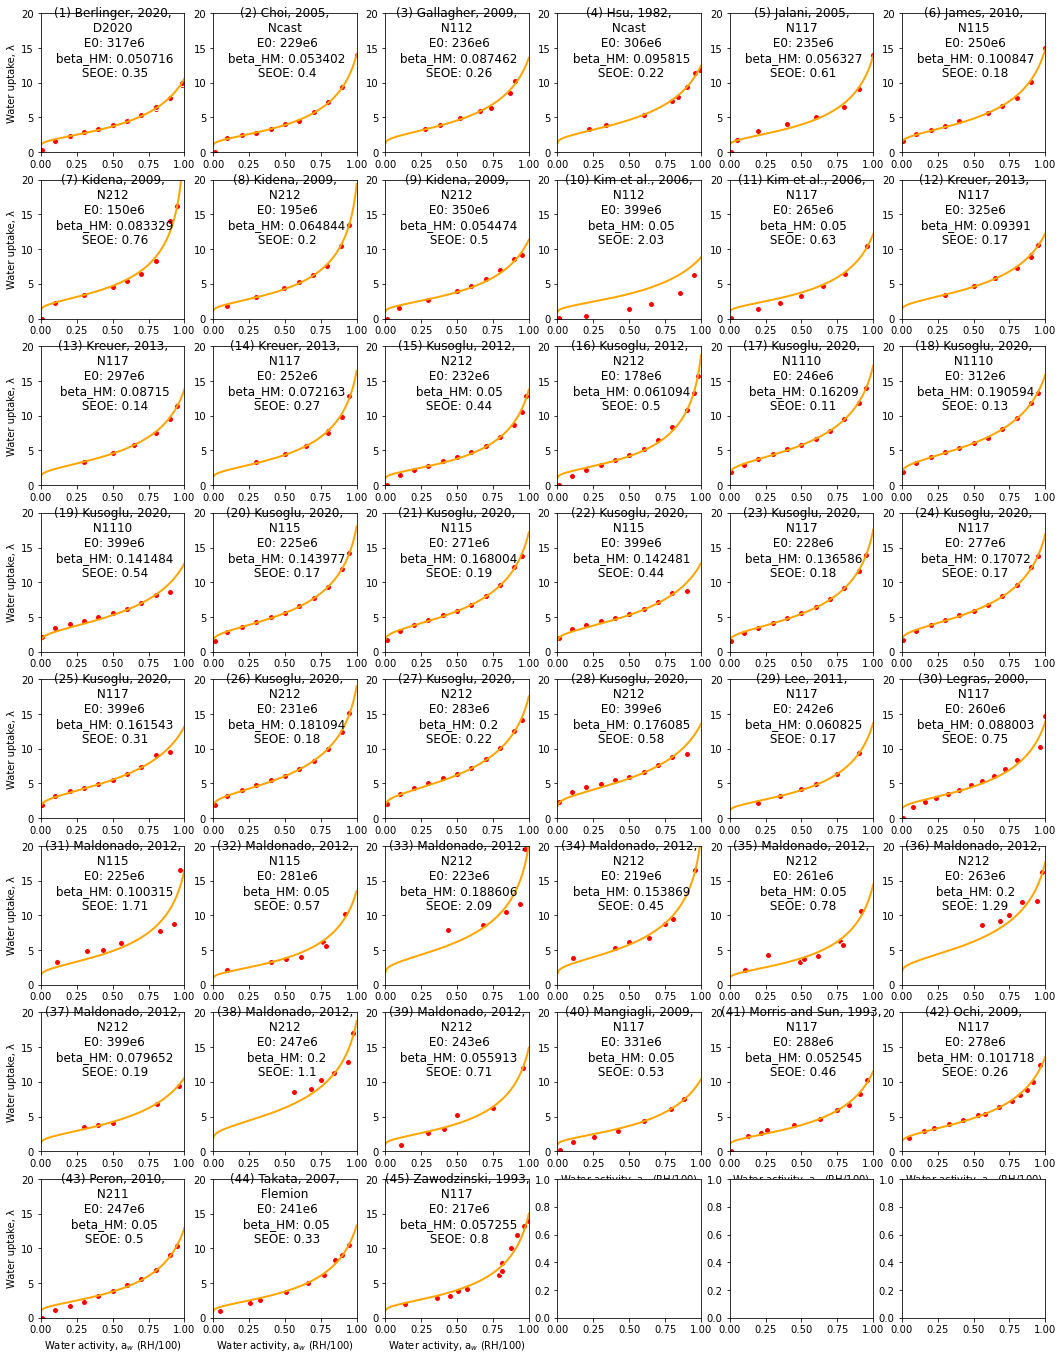

In [19]:
plot_size=3 
dim=subplot_dim_control(plot_count)
fig=plt.subplots(dim[0],dim[1],figsize=(dim[1]*plot_size, dim[0]*plot_size));

for i in range(0,plot_count): 
    df_gi = df_grouped[i:i+1];
    df_sub = pd.merge(left=df[data_columns], right=df_gi[group_by_columns], how='inner', on=group_by_columns);
    RH_list = [x/100 for x in df_sub['RH'].tolist()];
    y_lambda = df_sub['lambda'].to_list();
    plt.subplot(dim[0],dim[1],i+1);
    plt.scatter( RH_list, y_lambda, c='red', marker='o', edgecolors='w');
    plot_from_lambda(saved_simplified_lambdas[i])
    ttl=plt.title(f"({i+1}) {df_gi['Study'].values[0]}, {df_gi['Year'].values[0]},\n {df_gi['Membrane'].values[0]} \
                  \n E0: {int(E0_simplified_lst[i]/1e6)}e6\n beta_HM: {round(beta_HM_simplified_lst[i],6)}\
                  \n MSE: {round(MSE_simplified_lst[i],2)}"
              ,x=0.5,y=0.5)
    if i%dim[1]==0:             #only show y_label for leftmost plots
        plt.ylabel('Water uptake, λ')    
    if (plot_count-i)<=dim[1]:  #only show x_label for bottom plots
        plt.xlabel('Water activity, a$_w$ (RH/100)')

    plt.xlim(0, 1);
    plt.ylim(0, 20);
#plt.savefig("Priyam_thermo_simplified_raw.png",format='png')

Full Thermo [this part takes a long time to run] (Full_Thermo.py)

In [93]:
all=df_grouped.shape[0]
plot_count=all #change the number of subplot to graph (for quicker testing)
E0_full_lst,beta_HM_full_lst,MSE_full_lst,saved_full_lambdas=[],[],[],[]

def res(fit_params):
       E0,beta_HM=fit_params
       return list(np.subtract(y_lambda_adjusted,Res_Params_CurveFit(RH_list,E0,beta_HM))) # can use Res_PhaseEqb here too for better syntax. not important.



for i in range(plot_count):
       start_time=time.time()
       df_gi = df_grouped[i:i+1];
       df_sub = pd.merge(left=df[data_columns], right=df_gi[group_by_columns], how='inner', on=group_by_columns);
       RH_list = [x/100 for x in df_sub['RH'].tolist()];
       y_lambda = df_sub['lambda'].to_list();

       # Right now we are using the raw data so compensate=0, Full model fails after LRH adjustment, so I left it in here in case 
       # you want to try it out
       if RH_list[0]<0.25: 
              compensate=0 # set to y_lambda[0] if you want to sink datapoints.
              y_lambda_adjusted= [x - compensate for x in y_lambda]
       else:
              y_lambda_adjusted=y_lambda


       exp_Temp=df_sub.Temperature[0]+273.15 # operating temperature in Full_Thermo.py frame
       Global_Temp_set(exp_Temp)  


       popt, pcov = sp.optimize.curve_fit(Res_Params_CurveFit, RH_list, y_lambda_adjusted, bounds=([150e6,0.05],[400e6,0.2]));

       E0_full_lst.append(popt[0])
       beta_HM_full_lst.append(popt[1])
       saved_full_lambdas.append(save_pred_full_lambda(popt[0],popt[1]))

       predicted_exp_lambda=Res_Params_CurveFit(RH_list,popt[0], popt[1]);
       MSE=sqrt(sum([a**2 for a in np.subtract(np.array(predicted_exp_lambda),np.array(y_lambda_adjusted))])/len(y_lambda_adjusted))
       MSE_full_lst.append(MSE)

       end_time=time.time()
       print(f"finished ({i+1}) in {round(end_time-start_time,3)} seconds")
print(f"Cumulative MSE: {sum(MSE_full_lst)}")
#plt.savefig("Priyam_thermo_full_raw.png",format='png')

finished (1) in 9.234 seconds
finished (2) in 5.028 seconds
finished (3) in 5.511 seconds
finished (4) in 6.347 seconds
finished (5) in 5.695 seconds
finished (6) in 6.259 seconds
finished (7) in 5.768 seconds
finished (8) in 5.528 seconds
finished (9) in 6.065 seconds
finished (10) in 6.422 seconds
finished (11) in 5.646 seconds


KeyboardInterrupt: 

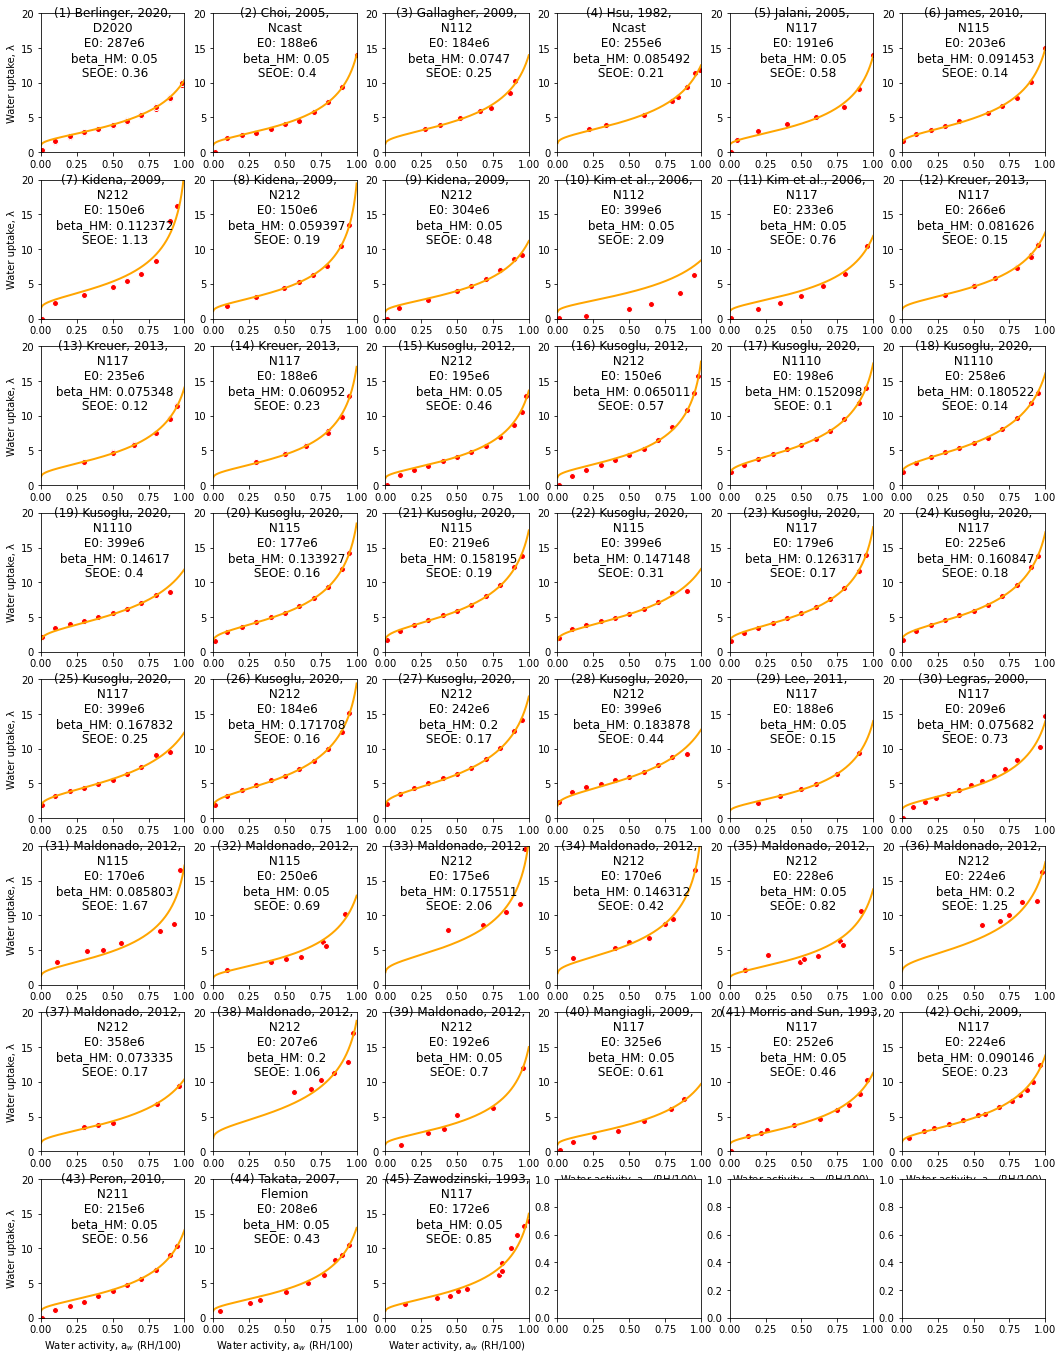

In [35]:
plot_size=3 
dim=subplot_dim_control(plot_count)
fig=plt.subplots(dim[0],dim[1],figsize=(dim[1]*plot_size, dim[0]*plot_size));

for i in range(0,plot_count): 
    df_gi = df_grouped[i:i+1];
    df_sub = pd.merge(left=df[data_columns], right=df_gi[group_by_columns], how='inner', on=group_by_columns);
    RH_list = [x/100 for x in df_sub['RH'].tolist()];
    y_lambda = df_sub['lambda'].to_list();
    plt.subplot(dim[0],dim[1],i+1);
    plt.scatter( RH_list, y_lambda, c='red', marker='o', edgecolors='w');
    plot_from_lambda(saved_full_lambdas[i])
    ttl=plt.title(f"({i+1}) {df_gi['Study'].values[0]}, {df_gi['Year'].values[0]},\n {df_gi['Membrane'].values[0]}\
                    \n E0: {int(E0_full_lst[i]/1e6)}e6\n beta_HM: {round(beta_HM_full_lst[i],6)}\
                    \n MSE: {round(MSE_full_lst[i],2)}"
              ,x=0.5,y=0.5)
    if i%dim[1]==0:             #only show y_label for leftmost plots
        plt.ylabel('Water uptake, λ')    
    if (plot_count-i)<=dim[1]:  #only show x_label for bottom plots
        plt.xlabel('Water activity, a$_w$ (RH/100)')

    plt.xlim(0, 1);
    plt.ylim(0, 20);
#plt.savefig("Priyam_thermo_full_raw.png",format='png')

Error Comparison

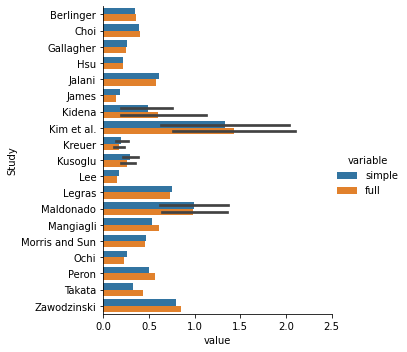

In [58]:
error_df=pd.DataFrame({
    'Study':df_grouped['Study'],
    'simple':MSE_simplified_lst,
    'full':MSE_full_lst
    }
)
raw_err=pd.melt(error_df, id_vars=['Study'], value_vars=['simple', 'full'])
graph1=sns.catplot(y="Study", x="value", data=raw_err,hue='variable',kind='bar',orient='h') # that value is MSE
graph1.set(xlim=(0,2.5))

Parameter Comparison

In [70]:
df_fit_params=pd.DataFrame(
    {
        'Study':df_grouped['Study'],
        'beta_simple':beta_HM_simplified_lst,
        'beta_full': beta_HM_full_lst,
        'E0_simple': [x/10e7 for x in E0_simplified_lst],
        'E0_full': [x/10e7 for x in E0_full_lst]
    }
)
df_fit_params.head(5)

,Study,beta_simple,beta_full,E0_simple,E0_full
1,Berlinger,0.050716,0.050000,3.178219,2.877410
2,Choi,0.053402,0.050000,2.297688,1.885075
3,Gallagher,0.087462,0.074700,2.364851,1.847858
4,Hsu,0.095815,0.085492,3.067227,2.551079
5,Jalani,0.056327,0.050000,2.359406,1.911111


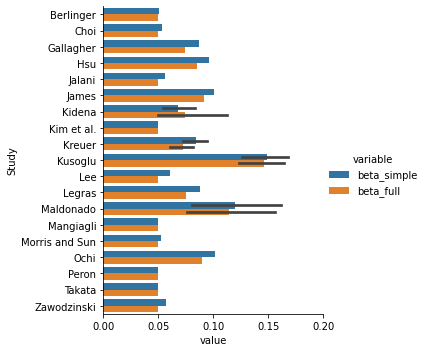

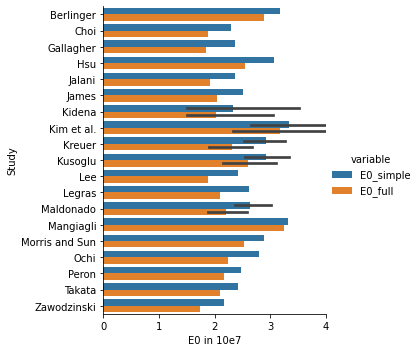

In [75]:
df_beta=pd.melt(df_fit_params, id_vars=['Study'], value_vars=['beta_simple', 'beta_full'])
df_E0=pd.melt(df_fit_params, id_vars=['Study'], value_vars=['E0_simple', 'E0_full'])
df_E0.columns=['Study', 'variable', 'E0 in 10e7']

graph2=sns.catplot(y="Study", x="value", data=df_beta,hue='variable',kind='bar',orient='h')
graph2.set(xlim=(0,0.2))
graph3=sns.catplot(y="Study", x="E0 in 10e7", data=df_E0,hue='variable',kind='bar',orient='h')
graph3.set(xlim=(0,4))